In [187]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
import datetime
import pandas as pd
import toml
import polars as pl
from cv2 import aruco
from datetime import datetime
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *
from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

## Calibration file import

In [188]:
_webcam_calib_pth = r"E:\CMC\pyprojects\DeepVision\recorded_data\paper\calibration_00\webcam_calibration.msgpack"
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

In [189]:
_name = 'five_rotation_t0'

_base_dir = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), 'recorded_data', 'five_marker_validation')
_data_pth = os.path.join(_base_dir, _name)
_video_binary_file = os.path.join(_data_pth, 'webcam_color.msgpack')
_video_timestamp_file = os.path.join(_data_pth, 'webcam_timestamp.msgpack')

In [190]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

In [191]:
ts_pth = os.path.join(_video_timestamp_file)
with open(ts_pth, "rb") as ts_file:
    ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
    ts = list(ts_unpacker)

In [192]:
            
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [193]:
_video = open(_video_binary_file, 'rb')
_video_file = mp.Unpacker(_video, object_hook=mpn.decode)

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}
counter = 0

for _frame in tqdm(_video_file):
    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedpoints = detector.detectMarkers(_frame)
    # refine corners
    corners, ids, rejectedpoints,_ = detector.refineDetectedMarkers(image=_frame,board=board ,detectedCorners=corners, detectedIds=ids, rejectedCorners=rejectedpoints, cameraMatrix=_webcam_cam_mat, distCoeffs=_webcam_dist)
    rvec, tvec  = estimatePoseSingleMarkers(corners=corners, marker_size=0.05, mtx=_webcam_cam_mat, distortion=_webcam_dist)
    
    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)
    counter += 1

354it [00:03, 103.83it/s]


In [194]:
default_ids = [12, 14, 20, 88, 89]
coordinate = {str(id): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []} for id in default_ids}

for i, frame_id in enumerate(data["frame_id"]):
    if data["marker_ids"][i] is not None:
        existing_ids = set(data["marker_ids"][i].reshape(-1))
        missing_ids = set(default_ids) - existing_ids
        
        for _m, tvec, rvec in zip(data["marker_ids"][i], data["tvec"][i], data["rvec"][i]):
            if _m in default_ids:
                coord = coordinate[str(_m[0])]
                coord["x"].append(tvec[0][0])
                coord["y"].append(tvec[0][1])
                coord["z"].append(tvec[0][2])
                coord["rx"].append(rvec[0][0])
                coord["ry"].append(rvec[0][1])
                coord["rz"].append(rvec[0][2])
        
        for _m in missing_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)
    else:
        for _m in default_ids:
            coord = coordinate[str(_m)]
            coord["x"].append(np.nan)
            coord["y"].append(np.nan)
            coord["z"].append(np.nan)
            coord["rx"].append(np.nan)
            coord["ry"].append(np.nan)
            coord["rz"].append(np.nan)

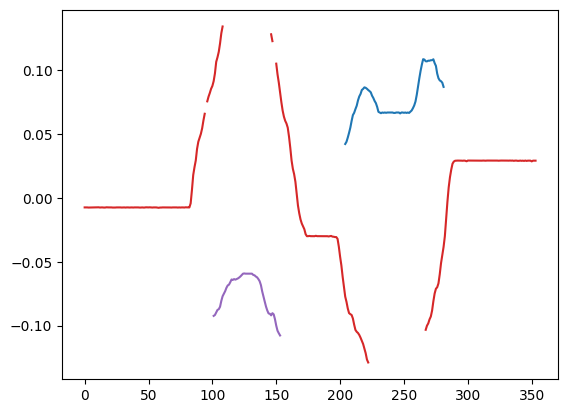

In [195]:
plt.plot(coordinate['12']['x'])
plt.plot(coordinate['14']['x'])
plt.plot(coordinate['20']['x'])
plt.plot(coordinate['88']['x'])
plt.plot(coordinate['89']['x'])

## The offset of center position from each markers

In [196]:
id_12_offset = np.array([-0.054, 0.031, -0.069]).reshape(3,1)
id_88_offset = np.array([0.00, 0.031, -0.1075]).reshape(3,1)
id_89_offset = np.array([-0.054, 0.031, -0.069]).reshape(3,1)
id_14_offset = np.array([0.00, 0.1025, -0.069]).reshape(3,1)
id_20_offset = np.array([0.00, 0.01, -0.069]).reshape(3,1)

## Transforming the coordinates to center

In [197]:
_r_12 = R.from_rotvec(np.array([coordinate['12']['rx'], coordinate['12']['ry'], coordinate['12']['rz']]).T).as_matrix()
_tvec_12 = np.array([coordinate['12']['x'], coordinate['12']['y'], coordinate['12']['z']])
_t_12 = np.array([(_r @ id_12_offset + _t.reshape(3,1)).T[0] for _r, _t in zip(_r_12, _tvec_12.T)])

_r_14 = R.from_rotvec(np.array([coordinate['14']['rx'], coordinate['14']['ry'], coordinate['14']['rz']]).T).as_matrix()
_tvec_14 = np.array([coordinate['14']['x'], coordinate['14']['y'], coordinate['14']['z']])
_t_14 = np.array([(_r @ id_14_offset + _t.reshape(3,1)).T[0] for _r, _t in zip(_r_14, _tvec_14.T)])

_r_20 = R.from_rotvec(np.array([coordinate['20']['rx'], coordinate['20']['ry'], coordinate['20']['rz']]).T).as_matrix()
_tvec_20 = np.array([coordinate['20']['x'], coordinate['20']['y'], coordinate['20']['z']])
_t_20 = np.array([(_r @ id_20_offset + _t.reshape(3,1)).T[0] for _r, _t in zip(_r_20, _tvec_20.T)])

_r_88 = R.from_rotvec(np.array([coordinate['88']['rx'], coordinate['88']['ry'], coordinate['88']['rz']]).T).as_matrix()
_tvec_88 = np.array([coordinate['88']['x'], coordinate['88']['y'], coordinate['88']['z']])
_t_88 = np.array([(_r @ id_88_offset + _t.reshape(3,1)).T[0] for _r, _t in zip(_r_88, _tvec_88.T)])

_r_89 = R.from_rotvec(np.array([coordinate['89']['rx'], coordinate['89']['ry'], coordinate['89']['rz']]).T).as_matrix()
_tvec_89 = np.array([coordinate['89']['x'], coordinate['89']['y'], coordinate['89']['z']])
_t_89 = np.array([(_r @ id_89_offset + _t.reshape(3,1)).T[0] for _r, _t in zip(_r_89, _tvec_89.T)])


"""Transforming to world coordinate"""
_gt_12 = _r_88[0].T @ (_t_12 - _tvec_88.T[0]).T
_gt_14 = _r_88[0].T @ (_t_14 - _tvec_88.T[0]).T
_gt_20 = _r_88[0].T @ (_t_20 - _tvec_88.T[0]).T
_gt_88 = _r_88[0].T @ (_t_88 - _tvec_88.T[0]).T
_gt_89 = _r_88[0].T @ (_t_89 - _tvec_88.T[0]).T

## Optimized

In [254]:

# Define offsets
offsets = {
    12: np.array([-0.09, 0.031, -0.069]),
    14: np.array([0.00, 0.1025, -0.069]),
    20: np.array([0.00, 0.01, -0.069]),
    88: np.array([0.00, 0.031, -0.1075]),
    89: np.array([0.1, 0.031, -0.069])
}

# Function to compute transformed coordinates
def compute_transformed_coordinates(coordinate, id_offset):
    rotation_matrix = R.from_rotvec(np.array([coordinate['rx'], coordinate['ry'], coordinate['rz']]).T).as_matrix()
    translation_vector = np.array([coordinate['x'], coordinate['y'], coordinate['z']])
    transformed = np.array([(_r @ id_offset.reshape(3,1) + _t.reshape(3,1)).T[0] for _r, _t in zip(rotation_matrix, translation_vector.T)])
    return rotation_matrix, translation_vector, transformed

# Compute transformations
results = {}
for key in [12, 14, 20, 88, 89]:
    results[key] = compute_transformed_coordinates(coordinate[str(key)], offsets[key])

# Transform to global coordinates
_r_88_inv = results[88][0][0].T
_tvec_88_0 = results[88][1].T[0]

world_coordinates = {}
for key in offsets.keys():
    world_coordinates[key] = _r_88_inv @ (results[key][2] - _tvec_88_0).T

_gt_12, _gt_14, _gt_20, _gt_88, _gt_89 = [world_coordinates[key] for key in [12, 14, 20, 88, 89]]

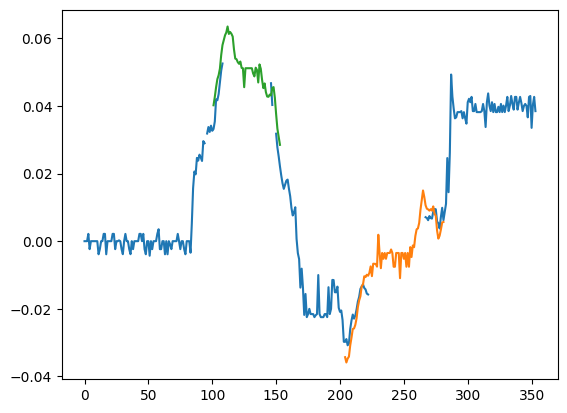

In [255]:
# plt.plot(_tvec_88.T)
plt.plot(_gt_88[0])
plt.plot(_gt_12[0])
plt.plot(_gt_89[0])

## reading mocap file

In [256]:
_mocap_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), 'recorded_data', 'five_marker_validation', 'mocap', f'{_name}.csv')
_mocap_df, st_time = read_rigid_body_csv(_mocap_path)
_mocap_df = pl.from_pandas(_mocap_df)

e:\CMC\pyprojects\DeepVision\wearable\..\support\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [257]:
_mocap_quat = R.from_quat(_mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']][0].to_numpy())
_mocap_mat = _mocap_quat.as_matrix()[0]

In [258]:
_m = get_rb_marker_name(7)
_m_org = _mocap_df[[_m['x'], _m['y'], _m['z']]][0].to_numpy().T
_m_tvec = _mocap_df[[_m['x'], _m['y'], _m['z']]].to_numpy().T
_m_transformed = _mocap_mat.T @ (_m_tvec - _m_org)

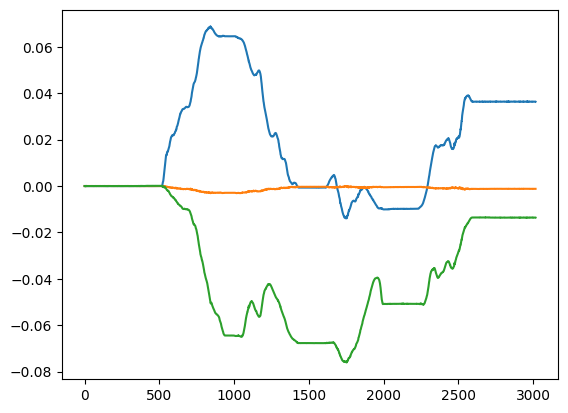

In [259]:
plt.plot(_m_transformed.T)

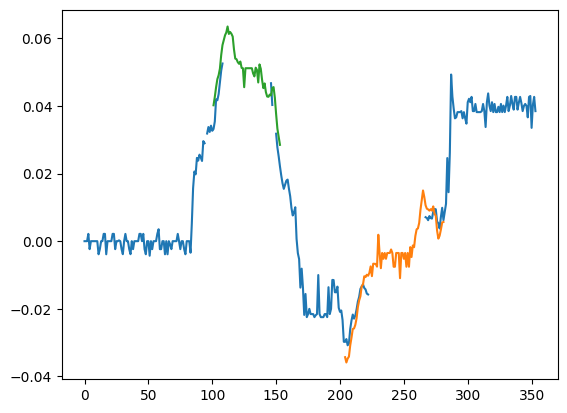

In [260]:
plt.plot(_gt_88[0])
plt.plot(_gt_12[0])
plt.plot(_gt_89[0])